<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Библиотеки" data-toc-modified-id="Библиотеки-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Библиотеки</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка" data-toc-modified-id="Загрузка-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Загрузка</a></span></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Ресемплирование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Признаки" data-toc-modified-id="Признаки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Признаки</a></span><ul class="toc-item"><li><span><a href="#split" data-toc-modified-id="split-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>split</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Случайный лес</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Библиотеки

In [1]:
#pip install catboost

In [2]:
#pip install lightgbm

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
# import seaborn as sns
import os
from catboost import CatBoostRegressor #, Pool
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

In [4]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'17.08.2022 00:43:48'

In [5]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Подготовка данных

### Загрузка

In [6]:
pth1 = '/datasets/'
pth2 = ''
fname = 'taxi.csv'
if os.path.exists(pth1+fname):
    df = pd.read_csv(pth1+fname, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2+fname):
    df = pd.read_csv(pth2+fname, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [7]:
print(df.index.is_monotonic)
# df.sort_index(inplace=True)

True


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


Имеются данные за полгода: с 01.03.2018 по 31.08.2018 - за каждые 10 минут.

### Ресемплирование

In [10]:
df = df.resample('1H').sum()

In [11]:
df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


## Анализ

In [12]:
df.num_orders.describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

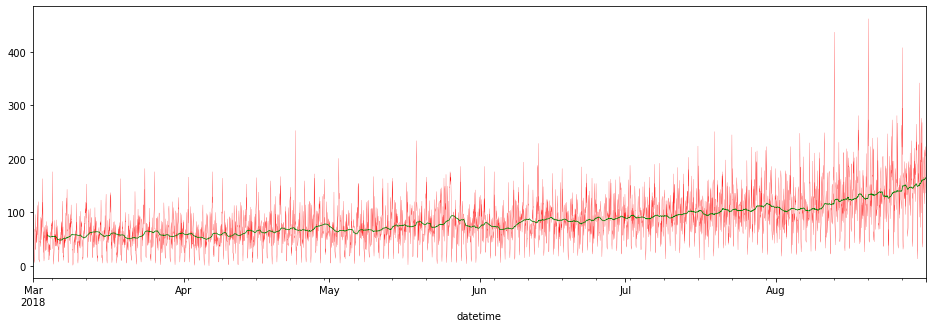

In [13]:
plt.figure(figsize=(16, 5))
plt.subplot()
df.plot(ax=plt.gca(), legend=False, color='red', linewidth=0.2)
df.rolling(72).mean().plot(ax=plt.gca(), legend=False, color='green', linewidth=0.7);

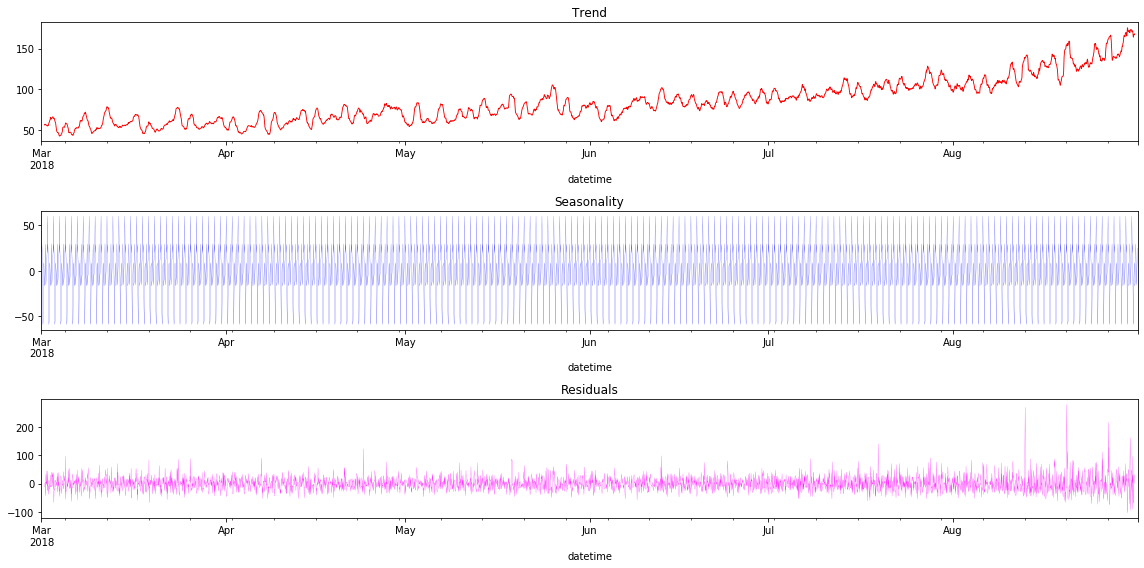

In [14]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(16, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), legend=False, color='red', linewidth=0.9)
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), legend=False, color='blue', linewidth=0.15)
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), legend=False, color='fuchsia', linewidth=0.2)
plt.title('Residuals')

plt.tight_layout();

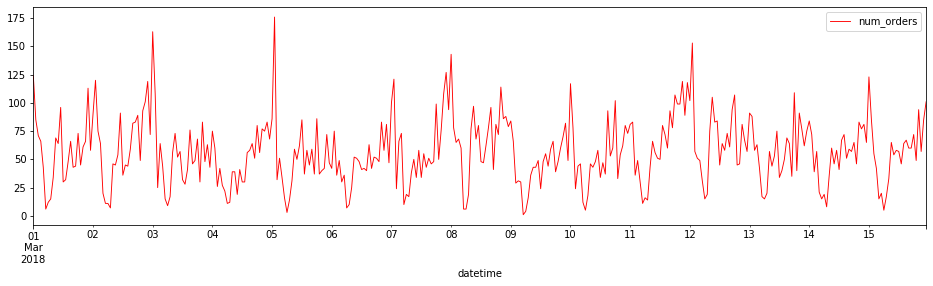

In [15]:
plt.figure(figsize=(16, 4))
plt.subplot()
df['2018-03-01':'2018-03-15'].plot(ax=plt.gca(), legend=True, color='red', linewidth=0.9);

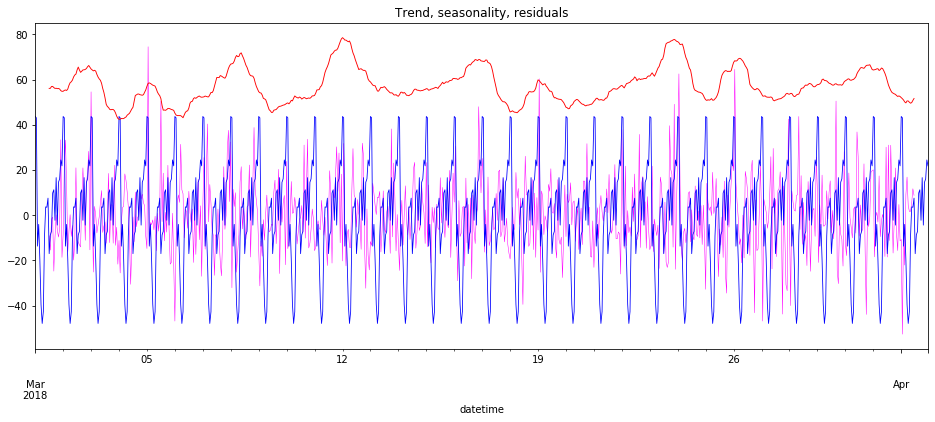

In [16]:
decomposed = seasonal_decompose(df['2018-03-01':'2018-04-01'])

plt.figure(figsize=(16, 6))
plt.subplot()
decomposed.resid.plot(ax=plt.gca(), legend=False, color='fuchsia', linewidth=0.5)
decomposed.seasonal.plot(ax=plt.gca(), legend=False, color='blue', linewidth=0.8) 
decomposed.trend.plot(ax=plt.gca(), legend=False, color='red', linewidth=0.9)
plt.title('Trend, seasonality, residuals');

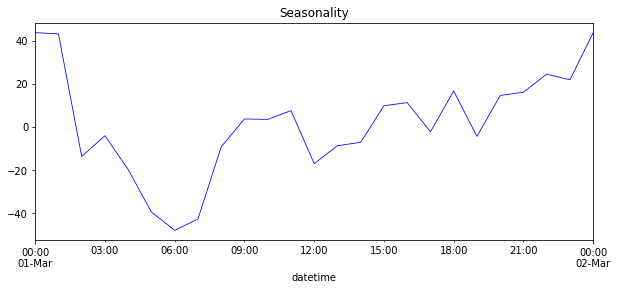

In [17]:
decomposed = seasonal_decompose(df['2018-03-01':'2018-04-01'])

plt.figure(figsize=(10, 4))
plt.subplot()
decomposed.seasonal['2018-03-01':'2018-03-02 00:00:00'].plot(ax=plt.gca(), legend=False, color='blue', linewidth=0.8) 
plt.title('Seasonality');

На протяжении всего периода тренд возрастает, а также стали больше амплитуды пиков на графике остатков, особенно в последний месяц. Сезонность в полученном разложении - это суточные колебания, которые в контексте данных (заказы такси из аэропорта) могут быть обусловлены, например, графиком регулярных рейсов, отсутствием рейсовых автобусов до города в ночное время.

## Признаки

In [18]:
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour

for lag in [1,2,3,4, 8, 12,  
            24, 48, 72,     # сутки, двое, трое назад
            168             # 24*7 - неделю назад
           ]:
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

df['rolling_mean_24'] = df['num_orders'].shift().rolling(24).mean()
df['rolling_mean_48'] = df['num_orders'].shift().rolling(48).mean()
df['rolling_mean_72'] = df['num_orders'].shift().rolling(72).mean()

df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_8,lag_12,lag_24,lag_48,lag_72,lag_168,rolling_mean_24,rolling_mean_48,rolling_mean_72
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### split

In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
train_1, valid = train_test_split(train, shuffle=False, test_size=0.1)

target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
target_train_1 = train_1['num_orders']
features_train_1 = train_1.drop('num_orders', axis=1)
target_valid = valid['num_orders']
features_valid = valid.drop('num_orders', axis=1)
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

In [20]:
print(train_1.index.min())
print(train_1.index.max())
print(valid.index.min())
print(valid.index.max())
print(test.index.min())
print(test.index.max())

2018-03-08 00:00:00
2018-07-28 16:00:00
2018-07-28 17:00:00
2018-08-13 13:00:00
2018-08-13 14:00:00
2018-08-31 23:00:00


## Обучение

### Линейная регрессия

In [21]:
%%time

lr_model = LinearRegression(n_jobs=4, fit_intercept=True, normalize=True )
lr_model.fit(features_train_1, target_train_1)
predicted_lr = lr_model.predict(features_valid)
print(f"\nRMSE on valid: {mean_squared_error(target_valid, predicted_lr)**0.5:3.2f}\n")

lr_model.fit(features_train, target_train);


RMSE on valid: 29.42

Wall time: 18.3 ms


LinearRegression(n_jobs=4, normalize=True)

### CatBoost

In [22]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'17.08.2022 00:43:51'

In [23]:
%%time

cat_model = CatBoostRegressor(iterations=201, loss_function="RMSE", eval_metric='RMSE', verbose=0, thread_count=4
#                               ,learning_rate=0.125,
#                               depth=4,
#                               l2_leaf_reg=1
                             )
params = {'learning_rate': np.linspace(0.12, 0.13, num=10), 
          'depth': range(3,5), 
          'l2_leaf_reg': range(1,2), 
         }

cat_model.randomized_search(params, X=features_train, y=target_train,
                            cv=3, n_iter=20,
                            partition_random_seed=1234, 
                            verbose=10, plot=True
                           );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 20.90592488
bestIteration = 32

0:	loss: 20.9059249	best: 20.9059249 (0)	total: 423ms	remaining: 8.04s

bestTest = 20.53746977
bestIteration = 92


bestTest = 20.71711995
bestIteration = 83


bestTest = 20.52302141
bestIteration = 144


bestTest = 20.54632601
bestIteration = 143


bestTest = 20.67917358
bestIteration = 58


bestTest = 20.46016264
bestIteration = 182


bestTest = 20.44616355
bestIteration = 102


bestTest = 20.65564004
bestIteration = 124


bestTest = 21.024848
bestIteration = 32


bestTest = 20.39394888
bestIteration = 126

10:	loss: 20.3939489	best: 20.3939489 (10)	total: 2.29s	remaining: 1.87s

bestTest = 20.53924228
bestIteration = 33


bestTest = 20.7517385
bestIteration = 33


bestTest = 20.58946114
bestIteration = 33


bestTest = 20.6050057
bestIteration = 33


bestTest = 20.38144927
bestIteration = 130


bestTest = 20.56002715
bestIteration = 34


bestTest = 20.47379209
bestIteration = 118


bestTest = 20.51893104
bestIteration = 34


bestTest = 20.4

{'params': {'depth': 4,
  'l2_leaf_reg': 1,
  'learning_rate': 0.12555555555555556},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
    

In [24]:
print(cat_model.get_best_score())
cat_model.get_params()

{'learn': {'RMSE': 17.375176323524375}}


{'iterations': 201,
 'loss_function': 'RMSE',
 'thread_count': 4,
 'verbose': 0,
 'eval_metric': 'RMSE',
 'depth': 4,
 'l2_leaf_reg': 1,
 'learning_rate': 0.12555555555555556}

In [25]:
%%time
cat_model.fit(X=features_train_1, y=target_train_1)

predicted_cat = cat_model.predict(features_valid)
print(f"\nRMSE on valid: {mean_squared_error(target_valid, predicted_cat)**0.5:3.2f}\n")

cat_model.fit(features_train, target_train);


RMSE on valid: 29.20

Wall time: 703 ms


In [26]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'17.08.2022 00:43:58'

### Случайный лес

In [27]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'17.08.2022 00:43:58'

In [28]:
%%time

best_rmse = 60
best_n_est = 0
best_depth = 0
for est in range(61,65,2):
    for depth in range (17,21,2):
        forest_model = RandomForestRegressor(random_state=12345, verbose=0,
                                             n_estimators=est, max_depth=depth, 
                                             max_leaf_nodes=None, min_samples_leaf=3)
        forest_model.fit(features_train_1, target_train_1)
        predicted_forest = forest_model.predict(features_valid)
        tmp = mean_squared_error(target_valid, predicted_forest)**0.5
        if tmp < best_rmse:
            best_n_est = est
            best_depth = depth
            best_rmse = tmp

print(f"\nRMSE on valid: {best_rmse:3.2f}\n")


RMSE on valid: 29.46

Wall time: 4.99 s


In [29]:
best_n_est

63

In [30]:
best_depth

19

In [31]:
%%time
forest_model = RandomForestRegressor(random_state=12345, verbose=0,
                                     n_estimators=best_n_est, max_depth=best_depth, 
                                     max_leaf_nodes=None, min_samples_leaf=3)
forest_model.fit(features_train, target_train);

Wall time: 1.44 s


RandomForestRegressor(max_depth=19, min_samples_leaf=3, n_estimators=63,
                      random_state=12345)

In [32]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'17.08.2022 00:44:04'

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Добавила randomized_search в Catboost и циклы в Random Forest.
    <br>
    <br>Можно ли использовать GridSearchCV, randomized_search? (Не нашла, как отключить Cross Validation в них, а для временных рядов она не подходит.)
    <br>Надо ли писать вручную циклы для подбора параметров?
</div>

<div class="alert alert-block alert-info">
<b>Комментарий ревьюера:</b>

При работе с временными рядами нельзя использовать стандартную кросс-валидацию, так как в определенный момент тренировочная выборка окажется позже валидационной. Поэтому лучше воспользоватся методами из sklearn:
</div>

```python
tscv = TimeSeriesSplit(n_splits=8) # надо посмотреть, как подобрать параметр и аргументировать
grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=tscv)
```

## Тестирование

In [33]:
%%time
predicted_test_lr = lr_model.predict(features_test)
print(f"Linear reg's final test RMSE:\t\t {mean_squared_error(target_test, predicted_test_lr)**0.5:3.2f}")

predicted_test_cat = cat_model.predict(features_test)
print(f"CatBoost's final test RMSE:\t\t {mean_squared_error(target_test, predicted_test_cat)**0.5:3.2f}")

predicted_test_forest = forest_model.predict(features_test)
print(f"Random forest's final test RMSE:\t {mean_squared_error(target_test, predicted_test_forest)**0.5:3.2f}\n")

Linear reg's final test RMSE:		 34.91
CatBoost's final test RMSE:		 38.33
Random forest's final test RMSE:	 38.72

Wall time: 33.9 ms


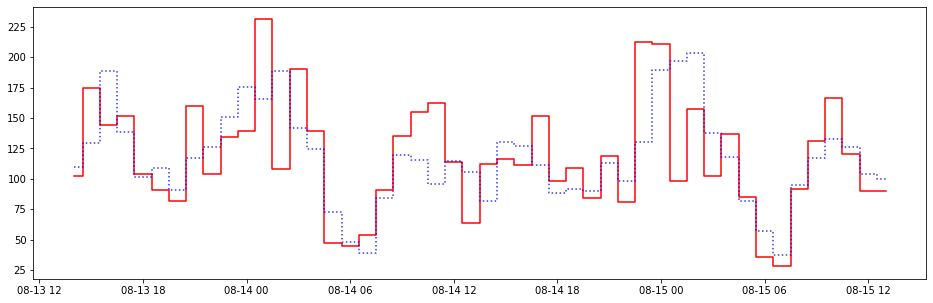

In [37]:
x = target_test[:48].index
y1 = np.array(target_test[:48])
y2 = np.array(predicted_test_lr[:48])

fig, ax = plt.subplots(figsize=(16,5))
plt.step(x, y1, figure=fig, where='mid', label='target', color='red')
plt.step(x, y2, figure=fig, where='mid', label='predict', color='blue', alpha=0.8, linestyle=':')
plt.show();

### Проверка на адекватность

Проверим на адекватность модели, сравнив с моделью, которая прогнозирует значением ряда сутки назад (по сезонности):

In [35]:
pred_previous = target_test.shift(24)
for i in range(24):
    pred_previous.iloc[i] = target_train.iloc[-1-i]
print(f"RMSE:\t {mean_squared_error(target_test, pred_previous)**0.5:3.2f}\n")

RMSE:	 57.04



### Вывод

Ресемплировали имеющиеся данные по заказам по одному часу (вместо 10 мин.).
Проанализировали тренд и сезонность:
- тренд возрастает;
- сезонность суточная.

Обучили 3 модели: линейную регрессию, CatBoost, случайный лес - с различными гиперпараметрами, проверили их на тестовой выборке (10% от исходных данных), а также сделали проверку на адекватность.

Все 3 модели прошли проверку на адекватность и удовлетворяют исходному условию $RMSE<48$.
<br>По качеству и времени обучения/предсказания в этот раз линейная регрессия оказалась лучшей моделью. Хотя результаты всех моделей отличаются друг от друга не очень существенно (в пределах ~10%).

In [36]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'17.08.2022 00:44:05'